<a href="https://colab.research.google.com/github/effepivi/gvxr-tutorials/blob/main/Source_parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 4

## X-ray source parameters ![gVXR](https://github.com/effepivi/gvxr-tutorials/blob/main/img/gvxr_logo.png?raw=1)

## Authors: Franck Vidal and Jean Michel L&eacute;tang

(version 1.1, 7 Mar 2023)

# Aims of this session

- Create X-ray sources of different shapes:
    - Parallel beam (e.g. synchrotron);
    - Cone-beam (e.g. X-ray tube);
        - Ideal case, i.e. infinitesimal point source;
        - Focal spot, i.e. more realistic.
- Visualise the source shape;
- Set the beam spectrum:
    - Monochromatic;
    - Polychromatic:
        - By hand;
        - Using a text file;
        - Using [xpecgen](https://github.com/Dih5/xpecgen) (a python package to calculate x-ray spectra generated in tungsten anodes using the model of [Med. Phys. 43, 4655.](https://doi.org/10.1118/1.4955120)).

In [30]:
from notebook import notebookapp
servers = list(notebookapp.list_running_servers())

is_running_on_Google_Colab = False

if len(servers) > 0:
    if servers[0]["notebook_dir"] == '/':
        print("This notebook is executed using Google Colab")

        from google.colab import output
        output.enable_custom_widget_manager()        

        !pip install -q ipympl

        is_running_on_Google_Colab = True
    else:
        print("This notebook is executed using Code Ocean")

This notebook is executed using Google Colab


In [31]:
%matplotlib widget

# Install gVXR, xraylib and xpecgen

Run the cell below

```python
!pip3 install --quiet --upgrade gvxr xraylib xpecgen
```

In [32]:
!pip3 install --quiet --upgrade gvxr xraylib xpecgen numpy==1.24

# Task 1: Initialise the simulation environment

By now, we should all be able to set up the simulation environment on our own.

1. Import the packages;
2. Create the OpenGL context with `gvxr.createWindow`;
3. Set the detector with `gvxr.setDetectorPosition`;
4. Set the detector up vector with `gvxr.setDetectorUpVector`;
5. Set the number of pixels with `gvxr.setDetectorNumberOfPixels`;
6. Set the pixel spacing with `gvxr.setDetectorPixelSize`;
7. Load the following samples.

---

### Step 1 of Task 1: Import the packages

We must import the Python packages as follows:


In [33]:
import os
import numpy as np

import matplotlib.pyplot as plt # Plotting`
from matplotlib.colors import LogNorm # Look up table`
from matplotlib.colors import PowerNorm # Look up table`

from gvxrPython3 import gvxr # Simulate X-ray images`

from gvxrPython3.utils import visualise # Visualise the 3D environment if k3D is supported
from gvxrPython3.utils import plotScreenshot # Visualise the 3D environment using Matplotlib
# from gvxrPython3.utils import loadSpekpySpectrum # Generate and load an X-ray spectrum using Spekpy
from gvxrPython3.utils import loadXpecgenSpectrum # Generate and load an X-ray spectrum using xpecgen

---

### Step 2 of Task 1: Create the OpenGL context

We may use `gvxr.createWindow`.

In [34]:
window_id = 0
visible = False
opengl_major_version = 4
opengl_minor_version = 5
backend = "EGL"
gvxr.createWindow(window_id, visible, backend, opengl_major_version, opengl_minor_version);

---

### Step 3 of Task 1: Set the detector position

We must use `gvxr.setDetectorPosition`. The detector position is x = 0.0 cm, y = 0.0 cm and z = -5.0 cm.

In [35]:
gvxr.setDetectorPosition(0, 0, -5, "cm")

--- 

### Step 4 of Task 1: Set the detector up vector

Call `gvxr.setDetectorUpVector(ix, jy, kz)` with `ix`, `jy`, `kz` corresponding to a unit vector that define the 3D orientation of the 2D detector. 
In this example, `ix` = 0, `jy` = 1, and `kz` = 0.

In [36]:
gvxr.setDetectorUpVector(0, 1, 0)

--- 

### Step 5 of Task 1: Set the number of pixels

We want to create a detector with 300 pixels along both directions. 
For this purpose, we use `gvxr.setDetectorNumberOfPixels`.


In [37]:
gvxr.setDetectorNumberOfPixels(300, 300)
half_image_width = 150

--- 

### Step 6 of Task 1: Set the pixel spacing

The space between the centre of two successive pixels is 0.5 mm along both directions. We must use `gvxr.setDetectorPixelSize`.

In [38]:
gvxr.setDetectorPixelSize(0.5, 0.5, "mm")

--- 

### Step 7 of Task 1: Load the samples and their material properties

The sample is made of 6 components, a matrix with spherical inserts of various material. 

| Label | fname | Material type | Material | Density |
|-------|-------|---------------|----------|---------|
| Matrix | `input_data/phantoms/plate_sphere_inserts/matrix.stl` | Element | C | N/A |
| Col_0 | `input_data/phantoms/plate_sphere_inserts/col_0.stl` | Element | Cu | N/A |
| Col_1 | `input_data/phantoms/plate_sphere_inserts/col_1.stl` | Element | Al | N/A |
| Col_2 | `input_data/phantoms/plate_sphere_inserts/col_2.stl` | Compound | SiC | 3.2 g/cm3 |
| Col_3 | `input_data/phantoms/plate_sphere_inserts/col_3.stl` | Mixture | Ti90Al6V4 | 4.42 g/cm3 |
| Col_4 | `input_data/phantoms/plate_sphere_inserts/col_4.stl` | Element | Fe | N/A |

Load all the corresponding STL files using `gvxr.loadMeshFile`. The vertex data in the STL files is stored in mm.
Depending on the type of material, we must use `gvxr.setElement`, `gvxr.setCompound`, `gvxr.setMixture`, and `gvxr.setDensity`.

In [39]:
parts_list = ["Matrix", "Col_0", "Col_1", "Col_2", "Col_3", "Col_4"]

part_files = ["input_data/phantoms/plate_sphere_inserts/matrix.stl",
               "input_data/phantoms/plate_sphere_inserts/col_0.stl",
               "input_data/phantoms/plate_sphere_inserts/col_1.stl",
               "input_data/phantoms/plate_sphere_inserts/col_2.stl",
               "input_data/phantoms/plate_sphere_inserts/col_3.stl",
               "input_data/phantoms/plate_sphere_inserts/col_4.stl"]

Download the Sample if needed

In [40]:
# The directory does not exist
if not os.path.exists("input_data"):
    
    # Create the directory
    os.mkdir("input_data")

# The directory does not exist
if not os.path.exists("input_data/phantoms"):
    
    # Create the directory
    os.mkdir("input_data/phantoms")

# The directory does not exist
if not os.path.exists("input_data/phantoms/plate_sphere_inserts"):
    
    # Create the directory
    os.mkdir("input_data/phantoms/plate_sphere_inserts")

for part_fname in part_files:
    if not os.path.exists(part_fname):
        print("Download the polygon mesh (%s)" % part_fname)
        import urllib.request
        url = "https://github.com/effepivi/gvxr-tutorials/raw/main/" + part_fname
        urllib.request.urlretrieve(url, part_fname)

fname = "utilities.py"
if not os.path.exists("utilities.py"):
    print("Download the Python file (%s)" % fname)
    import urllib.request
    url = "https://github.com/effepivi/gvxr-tutorials/raw/main/" + fname
    urllib.request.urlretrieve(url, fname)

In [41]:
for part_id, part_fname in zip(parts_list, part_files):
     gvxr.loadMeshFile(part_id, part_fname, "mm")      

gvxr.setElement("Matrix", "C");

gvxr.setElement("Col_0", "Cu")
gvxr.setElement("Col_1", "Al")

gvxr.setCompound("Col_2", "SiC");
gvxr.setDensity("Col_2",3.2, "g/cm3");

gvxr.setMixture("Col_3", "Ti90Al6V4");
gvxr.setDensity("Col_3", 4.42, "g/cm3");

gvxr.setElement("Col_4", "Fe")

<div class="alert alert-block alert-warning">
    <b>Note:</b> We want to change the colour of the matrix. Indeed, it embeds inner objects (spheres) that are not visible in the 3D visualisation if its surface remain fully opaque. We can change the colour of the matrix using `gvxr.setColour(ID, red, green, blue, opacity)`, making sure `opacity` is less than 1.
</div>


In [42]:
red = 102 / 255
green = 255 / 255
blue = 153 / 255
opacity = 0.1 # Transparent: 0, opaque: 1
gvxr.setColour("Matrix", red, green, blue, opacity)

# Shape of the X-ray source

As of today, gVXR supports 3 different source shapes:

- Parallel beam;
    - Ideal case, i.e. infinitesimal point source;
- Cone-beam:
    - Focal spot, i.e. more realistic.

The parallel beam geometry corresponds to synchrotron sources. 
To create one, set the source position with `gvxr.setSourcePosition`, then call `gvxr.useParallelBeam()`.

The cone-beam geometry corresponds to X-ray tubes. There are two cases. The first one is an infinitesimal point source. 
To create one, set the source position with `gvxr.setSourcePosition`, then call `gvxr.usePointSource()`. The image is sharp. 

However, it is more realistic to consider the actual focal spot size of the X-ray tube ([click for more details](https://www.creatis.insa-lyon.fr/~letang/x-ray-book/instrumentation.html#image-primitives)). In reality, X-ray projections are blurred. The blurring is due to i) the detector itself (the inherent unsharpnness) and we will see that in detail in the next Notebook, and ii) the non-punctuality of the source of radiation (geometric unsharpness). 

![geometric unsharpness](https://github.com/effepivi/gvxr-tutorials/blob/main/img/Unsharpness1.jpg?raw=1)

To create one, set the source position with `gvxr.setSourcePosition`, then call `gvxr.setFocalSpot(px, py, pz, s, units, N)`.
`px`, `py`, and `pz` are three floating-point values used to set the size centre of the focal spot, and `s` the sie of the focal spot. `units` is a unit of length, e.g. `"um"`, `"mm"` or `"cm"`.
In practice, this type of source is implemented by repeating several point sources within the focal spot. Integrating all the correspoding projections creates the geometric unsharpness. `N` is the number of sub-sources for each axis. 

<div class="alert alert-block alert-warning">
    <b>Note:</b> For one X-ray projection using the focal spot size, N<sup>3</sup> simulations with point sources are performed and integrated. If N is high, the simulation runtime will considerably increase.
</div>

Before we carry on, we make sure to zoom in in the 3D visualisation.

In [43]:
gvxr.setZoom(500)

---

### Task:

1. Set a monochromatic source. The photon energy is 100 keV. We use could `gvxr.setMonoChromatic(100,"keV",1)`;
2. Use a point source;
3. Set the source position to (0, 0, 20) in cm;
4. Compute an X-ray image and store it in a variable called `xray_image_point_source`;
5. Render the 3D visualisation with `gvxr.displayScene()`;
6. Take a screenshot with `gvxr.takeScreenshot()` and store it in a variable called `screenshot_point_source`.

In [44]:
gvxr.setMonoChromatic(100, "keV", 1)
gvxr.usePointSource()
gvxr.setSourcePosition(0, 0, 20, "cm")
xray_image_point_source = np.array(gvxr.computeXRayImage(), dtype=np.single)
gvxr.displayScene()
screenshot_point_source = gvxr.takeScreenshot()

---

### Task:

1. Use a parallel source (call `gvxr.useParallelSource()`);
2. Compute an X-ray image and store it in a variable called `xray_image_parallel_source`;
3. Render the 3D visualisation with `gvxr.displayScene()`;
4. Take a screenshot with `gvxr.takeScreenshot()` and store it in a variable called `screenshot_parallel_source`.

In [45]:
gvxr.useParallelSource()
xray_image_parallel_source = np.array(gvxr.computeXRayImage(), dtype=np.single)
gvxr.displayScene()
screenshot_parallel_source = gvxr.takeScreenshot()

---

### Task:

1. Use a cone-beam geometry with a focal spot of 0.5 cm along the 3 axes with `gvxr.setFocalSpot()`. Its position is (0, 0, 20, "cm"). Use $3 \times 3 \times 3$ sub-sources, i.e. `N` = 3;
2. Compute an X-ray image and store it in a variable called `xray_image_focal_spot`;
3. Render the 3D visualisation with `gvxr.displayScene()`;
4. Take a screenshot with `gvxr.takeScreenshot()` and store it in a variable called `screenshot_focal_spot`.

In [46]:
gvxr.setFocalSpot(0, 0, 20, 0.5, "cm", 3)
xray_image_focal_spot = np.array(gvxr.computeXRayImage(), dtype=np.single)
gvxr.displayScene()
screenshot_focal_spot = gvxr.takeScreenshot()

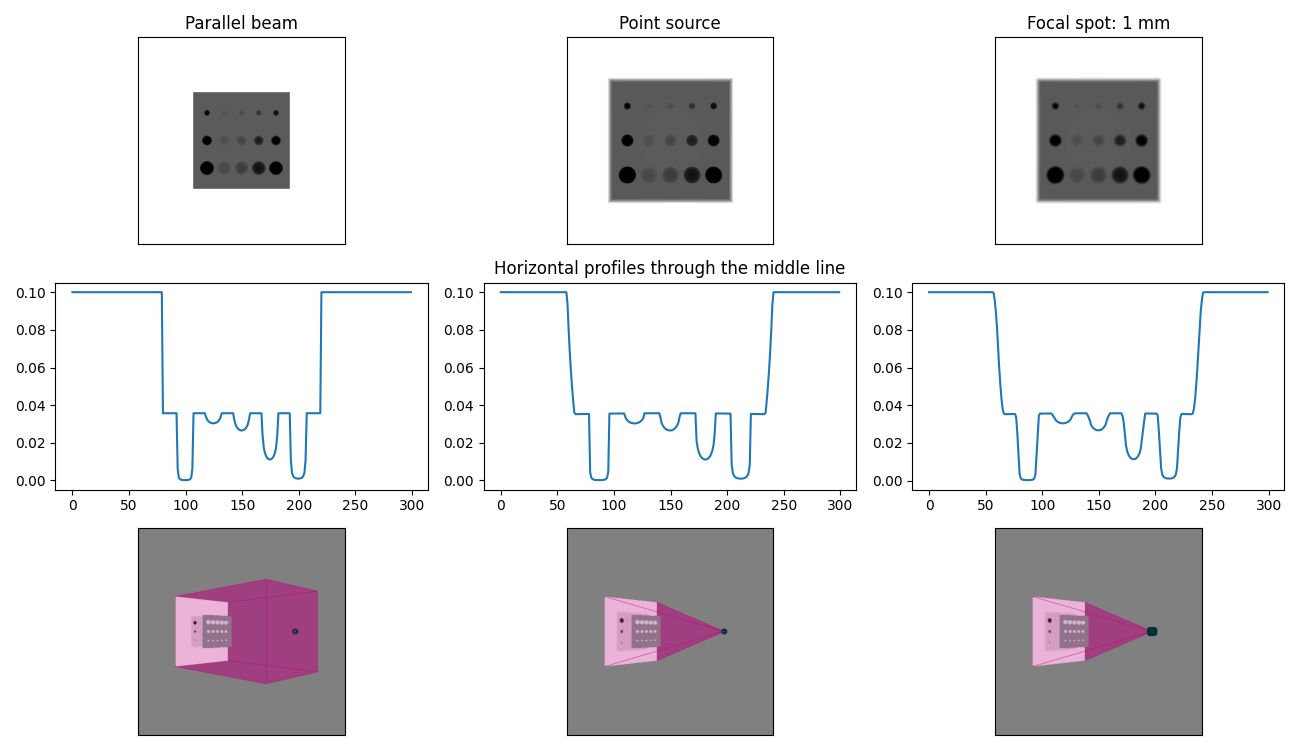

In [47]:
fig, axs = plt.subplots(3, 3, figsize=(13, 7.5))

axs[0, 0].imshow(xray_image_parallel_source, cmap="gray")
axs[0, 0].set_title("Parallel beam")
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])

axs[0, 1].imshow(xray_image_point_source, cmap="gray")
axs[0, 1].set_title("Point source")
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])

axs[0, 2].imshow(xray_image_focal_spot, cmap="gray")
axs[0, 2].set_title("Focal spot: 1 mm")
axs[0, 2].set_xticks([])
axs[0, 2].set_yticks([])

axs[1, 0].plot(xray_image_parallel_source[half_image_width])
# axs[1, 0].set_xlim([100, 500])

axs[1, 1].plot(xray_image_point_source[half_image_width])
axs[1, 1].set_title("Horizontal profiles through the middle line")
# axs[1, 1].set_xlim([100, 500])

axs[1, 2].plot(xray_image_focal_spot[half_image_width])
# axs[1, 2].set_xlim([100, 500])

axs[2, 0].imshow(screenshot_parallel_source)
axs[2, 0].set_xticks([])
axs[2, 0].set_yticks([])

axs[2, 1].imshow(screenshot_point_source)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])

axs[2, 2].imshow(screenshot_focal_spot)
axs[2, 2].set_xticks([])
axs[2, 2].set_yticks([])

plt.tight_layout()
plt.margins(0,0)

<div class="alert alert-block alert-warning">
    <b>Note:</b> Larger focal spots will introduce more blur. It may be necessary to increase the sampling rate of the focal spot (i.e. increase the value of N) to avoid some aliasing.
</div>

---
### Optional task:

You may i) re-run the previous two cells of code with a focal spot of 0.75 cm, ii) check the shape of the right-hand side profile, and iii) adjust `N` to remove the aliasing.

# X-ray spectra

If a beam spectrum is already loaded, you can erase it with `gvxr.resetBeamSpectrum()`.

## Monochromatic

When all the photons of the X-ray beam have the same energy, the beam is monochromatic. 
This is unrealistic for most simulation but it can be useful for testing. 
In synchrotron radiation, when a monochromator is used, the beam may be considered monochromatic.
There are two ways to create a monochromatic beam in gVXR. The following code snapshots are equivalent.

```python
gvxr.setMonoChromatic(energy, units, photon_count_per_ray)
```

or 

```python
gvxr.resetBeamSpectrum()
gvxr.addEnergyBinToSpectrum(energy, units, photon_count_per_ray)
```

`energy` is the energy of the incident photons, `units` is `"keV"` or `"MeV"`, and `photon_count_per_ray` is the number of photons of that energy per ray.

## Polychromatic

In practice, the incident beam has photons of a wide range of energy. 
Depending on the density of the area crossed by photons, low energy photons may be absorbed whilst high energy photons are more likely to reach the detector. 
Conceptually, this is equivalent to some kind of high-pass filter: only higher energies pass through, but the quantity will depend on the material crossed. 
This is **Beam Hardening**, a possible source of strong artefacts in computed tomography.

To generate a polychromatic beam in gVXR, just call `gvxr.addEnergyBinToSpectrum` with various energies.

### Synchrotron

Although monochromators are used in synchrotron tomography, the beam is not 100% monochromatic. It may be corrutpted by a few percent of harmonics. 
The code below will create a 33 keV beam that is almost monochromatic, with 2% of first order harmonics (66 keV), and 1% of second order harmonics (99 keV).

```python
gvxr.resetBeamSpectrum() # Make sure the beam is reset
gvxr.addEnergyBinToSpectrum(33, "keV", 0.97) # The energy of 97% of the photons is 33 keV
gvxr.addEnergyBinToSpectrum(66, "keV", 0.02) # The energy of 2% of the photons is 66 keV
gvxr.addEnergyBinToSpectrum(99, "keV", 0.01) # The energy of 1% of the photons is 66 keV
```

Keep note of the code, you'll use it to simulate some a CT scan in [Notebook 6](06-CT_acquisition.ipynb).

### X-ray tube

In most applications, whether radiography or tomography, whether medical or industrial, X-rays are generated with [X-ray tubes](https://www.creatis.insa-lyon.fr/~letang/x-ray-book/instrumentation.html#x-ray-production).
The cell below makes it possible to calculate spectra as generated by the X-ray tubes by specifying:
- the high voltage U of electrons acceleration,
- the thickness and the nature of the plate inserted.

These plates are located between the X-ray source and the scanned object. 
They are called "filters". 
Using the beam hardening principle, they are used to "clean" the spectra by stopping soft X-rays. 
It makes the beam more "monochromatic".
This is what the task below illustrates.

---
### Task:

1. Click on "Run Interact" below to generate the X-ray spectrum of an X-ray tube with a tungsten anode for a 100 kV tube voltage.
2. Change the tube voltage to 90 kV and click on "Run Interact". How did the figure change?
3. Change the tube voltage to 80 kV and click on "Run Interact". How did the figure change?
4. Change it back to 100 kV, then click on "Run Interact".
5. Add a plate of 5mm of copper, then click on "Run Interact". How did the figure change compare to the initial spectrum without the copper plate?

In [49]:
import ipywidgets as widgets
import utilities
widgets.interact_manual(utilities.spectrum,E0=widgets.IntText(value=100,step=1,description="High voltage (kV):",disabled=False,style={'description_width': 'initial'}),Mat_Z=widgets.Dropdown(options=[('Water',-1),('Aluminium',13),('Copper',29),('Lead',82)],value=-1,layout={'width': 'max-content'},description='Material:',style={'description_width': 'initial'}),Mat_X=widgets.FloatText(value=0.,step=0.01,description="Thickness (mm):",disabled=False,style={'description_width': 'initial'}));

interactive(children=(IntText(value=100, description='High voltage (kV):', style=DescriptionStyle(description_…

There are two main Python packages to generate realistic beam spectra from X-ray tubes.

1. [Spekpy](https://bitbucket.org/spekpy/spekpy_release/wiki/Home)
    - G Poludniowski, A Omar, R Bujila and P Andreo, Technical Note: SpekPy v2.0—a software toolkit for modeling x-ray tube spectra. Med Phys. 2021; DOI: [10.1002/mp.14945](https://doi.org/10.1002/mp.14945)
    - R Bujila, A Omar and G Poludniowski, A validation of SpekPy: a software toolkit for modelling x-ray tube spectra. Phys Med. 2020; 75:44-54. DOI: [10.1016/j.ejmp.2020.04.026](https://doi.org/10.1016/j.ejmp.2020.04.026)
2. [xpecgen](https://github.com/Dih5/xpecgen)
    - Hernández, G., Fernández F. 2016. "A model of tungsten x-ray anode spectra." Medical Physics, 43 4655. DOI: [10.1118/1.4955120](https://doi.org/10.1118/1.4955120)
    - Hernández, G., Fernández F. 2016. "xpecgen: A program to calculate x-ray spectra generated in tungsten anodes." The Journal of Open Source Software, 00062. DOI: [10.21105/joss.00062](https://doi.org/10.21105/joss.00062).
    
gVXR provides convenience functions to generate beam spectra using both packages:

- `loadSpekpySpectrum(kV, filters, angle)`
- `loadXpecgenSpectrum(kV, filters, angle)`

`kV` is the tube voltage in kV.
`filters` is an array of filters. Its default values is `None`. A filter is an array of two values. The first one is the symbol of a chemical element, e.g. `"Cu"` for copper, and a thickness in mm.
`angle` is the emission angle in degrees. Its default value is 12 degrees.

The function returns 4 variables, i) a dictionary whose keys are the photon energies, and the corresponding values are the number of photons, ii) an array of energies, iii) an array of corresponing photon counts, and iv) the corresponding units of energy.

For this course, we will be using `loadXpecgenSpectrum()`.

The example below creates a X-ray tube spectrum with a voltage of 100 kV. 
A 10 mm alluminium plate and a 5 mm copper plate are used for filtration.

`loadXpecgenSpectrum(100, [["Al", 10], ["Cu", 5]])`

A further convenience function allows us to load a spectrum from a text file:
`gvxr.loadSpectrumFromTSV(fname, units)`

In [50]:
def getAverageEnergy(k, f):
    
    avg = 0
    for energy, count in zip(k, f):
        avg += energy * count
        
    return avg / np.sum(f)

In [51]:
spectrum_unfiltered, k_unfiltered, f_unfiltered, units = loadXpecgenSpectrum(100)
xray_image_100kV_unfiltered = np.array(gvxr.computeXRayImage()) / gvxr.getTotalEnergyWithDetectorResponse()
average_energy_unfiltered = getAverageEnergy(k_unfiltered, f_unfiltered)
print("Average energy:", average_energy_unfiltered, units)

Average energy: 51.12002177412025 keV


In [52]:
spectrum_filtered, k_filtered, f_filtered, units = loadXpecgenSpectrum(100, filters=[["Cu", 5]])
xray_image_100kV_filtered = np.array(gvxr.computeXRayImage()) / gvxr.getTotalEnergyWithDetectorResponse()

average_energy_filtered = getAverageEnergy(k_filtered, f_filtered)
print("Average energy:", average_energy_filtered, units)

Average energy: 80.88601298445442 keV


---
### Task:

1. Set a monochromatic source. The Photon energy is 51 keV
2. Generate an the corresponding X-ray image.
    - Store it in a numpy array and divide every pixel value by `gvxr.getTotalEnergyWithDetectorResponse()`, e.g.
    - `xray_image_51keV = np.array(gvxr.computeXRayImage()) / gvxr.getTotalEnergyWithDetectorResponse()`
3. Set a monochromatic source. The Photon energy is 81 keV
4. Generate an the corresponding X-ray image.
    - Store it in a numpy array and divide every pixel value by `gvxr.getTotalEnergyWithDetectorResponse()`, e.g.
    - `xray_image_81keV = np.array(gvxr.computeXRayImage()) / gvxr.getTotalEnergyWithDetectorResponse()`

In [53]:
gvxr.setMonoChromatic(51, "keV", 1)
xray_image_51keV = np.array(gvxr.computeXRayImage()) / gvxr.getTotalEnergyWithDetectorResponse()

gvxr.setMonoChromatic(81, "keV", 1)
xray_image_81keV = np.array(gvxr.computeXRayImage()) / gvxr.getTotalEnergyWithDetectorResponse()

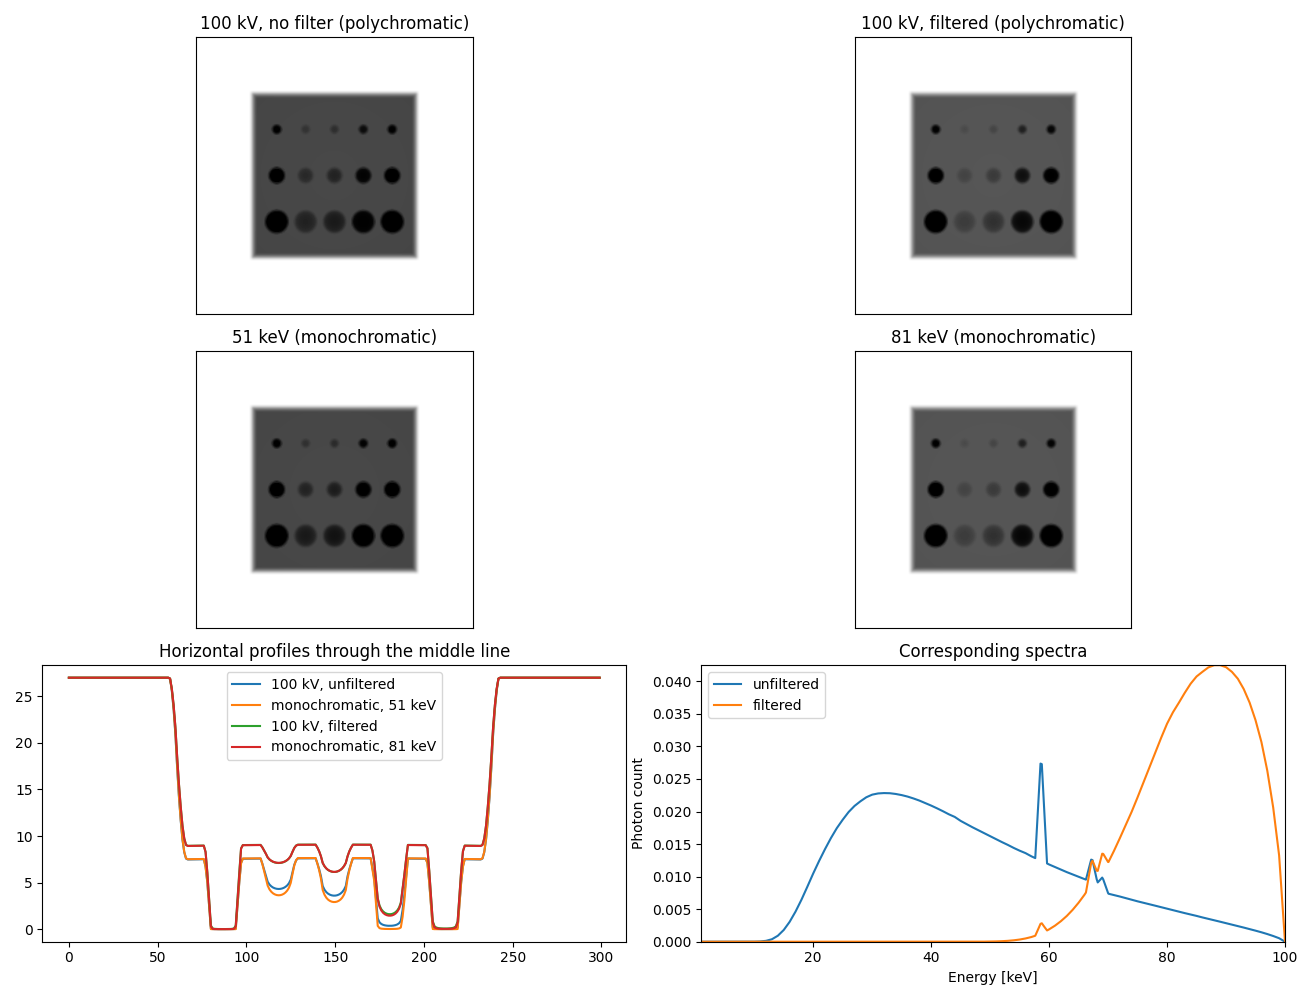

In [54]:
fig, axs = plt.subplots(3, 2, figsize=(13, 10))

axs[0, 0].imshow(xray_image_100kV_unfiltered, cmap="gray")
axs[0, 0].set_title("100 kV, no filter (polychromatic)")
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])

axs[0, 1].imshow(xray_image_100kV_filtered, cmap="gray")
axs[0, 1].set_title("100 kV, filtered (polychromatic)")
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])

axs[1, 0].imshow(xray_image_51keV, cmap="gray")
axs[1, 0].set_title("51 keV (monochromatic)")
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

axs[1, 1].imshow(xray_image_81keV, cmap="gray")
axs[1, 1].set_title("81 keV (monochromatic)")
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])

axs[2, 0].plot(xray_image_100kV_unfiltered[half_image_width], label="100 kV, unfiltered")
axs[2, 0].plot(xray_image_51keV[half_image_width], label="monochromatic, 51 keV")
axs[2, 0].plot(xray_image_100kV_filtered[half_image_width], label="100 kV, filtered")
axs[2, 0].plot(xray_image_81keV[half_image_width], label="monochromatic, 81 keV")
# axs[2, 0].set_xlim([100, 500])
axs[2, 0].legend()
axs[2, 0].set_title("Horizontal profiles through the middle line")


axs[2, 1].plot(k_unfiltered, f_unfiltered, label="unfiltered")
axs[2, 1].plot(k_filtered, f_filtered, label="filtered")
axs[2, 1].set_xlabel("Energy [" + units + "]")
axs[2, 1].set_ylabel("Photon count")
axs[2, 1].legend()
axs[2, 1].set_title("Corresponding spectra")

plt.tight_layout()
plt.margins(0,0)

From the profiles, we can see that the filtered beam spectrum and the corresponding monochromatic beam provide similar simulation results. This is, however, not the case for the filtered beam spectrum. The blue and orange curve differ significantly for the 4th sphere.

# Pixel size

Let us consider the example below. 
Imagine that the object size is unknown. We know:

- the soure-detector distance (SDD), 
- source-object distance (SOD) and 
- the physical space between the centre of two consecutive pixels (known as pixel spacing).

<div class="alert alert-block alert-warning">
    <b>Note:</b> There is no convention about how the SOD should be measured. The object position could be taken from the front, centre or back of the object. 
</div>


![](https://github.com/effepivi/gvxr-tutorials/blob/main/img/pixel_size.png?raw=1)

The projection of this object occupy 5 pixels of the detector, i.e. 3.5 cm. 
Using the Thales's theorem, we can take into account the perspective projection to compute the actual size of the object:

$$\text{pixel size} = \text{pixel spacing} \times \frac{SOD}{SDD}$$

In this example, 

$$\text{pixel size} = 0.7 \times \frac{9.9}{14.8} \\= 0.47$$

The pixel size in in the object plane is 0.47 cm.

The size of the object is

$$5 \times 0.47 \sim 2.4$$

We can plot again the X-ray images and profiles above to show the axes of the plots in centimetres.

In [55]:
from scipy.spatial import distance
source_position = gvxr.getSourcePosition("mm")
detector_position = gvxr.getDetectorPosition("mm")

number_of_pixels = np.array(gvxr.getDetectorNumberOfPixels())
detector_size = np.array(gvxr.getDetectorSize("mm"))
detector_element_spacing = detector_size / number_of_pixels

object_bbox = gvxr.getNodeAndChildrenBoundingBox("root", "mm")
object_position = [(object_bbox[0] + object_bbox[3]) / 2,
                   (object_bbox[1] + object_bbox[4]) / 2,
                   (object_bbox[2] + object_bbox[5]) / 2
                  ]

source_detector_distance = distance.euclidean(source_position, detector_position)
source_object_distance = distance.euclidean(source_position, object_position)

magnification = source_detector_distance / source_object_distance
pixel_size = detector_element_spacing * source_object_distance / source_detector_distance

In [56]:
print("Detector element spacing", detector_element_spacing, "mm")
print("SDD:", source_detector_distance, "mm")
print("SOD:", source_object_distance, "mm")
print("magnification:", magnification)
print("Pixel size in the object plane:", pixel_size)
print("Object width:", object_bbox[3] - object_bbox[0], "mm")
print("Object height:", object_bbox[4] - object_bbox[1], "mm")
print("Object depth:", object_bbox[5] - object_bbox[2], "mm")

Detector element spacing [0.5 0.5] mm
SDD: 250.0 mm
SOD: 200.0 mm
magnification: 1.25
Pixel size in the object plane: [0.4 0.4]
Object width: 70.0 mm
Object height: 70.0 mm
Object depth: 15.0 mm


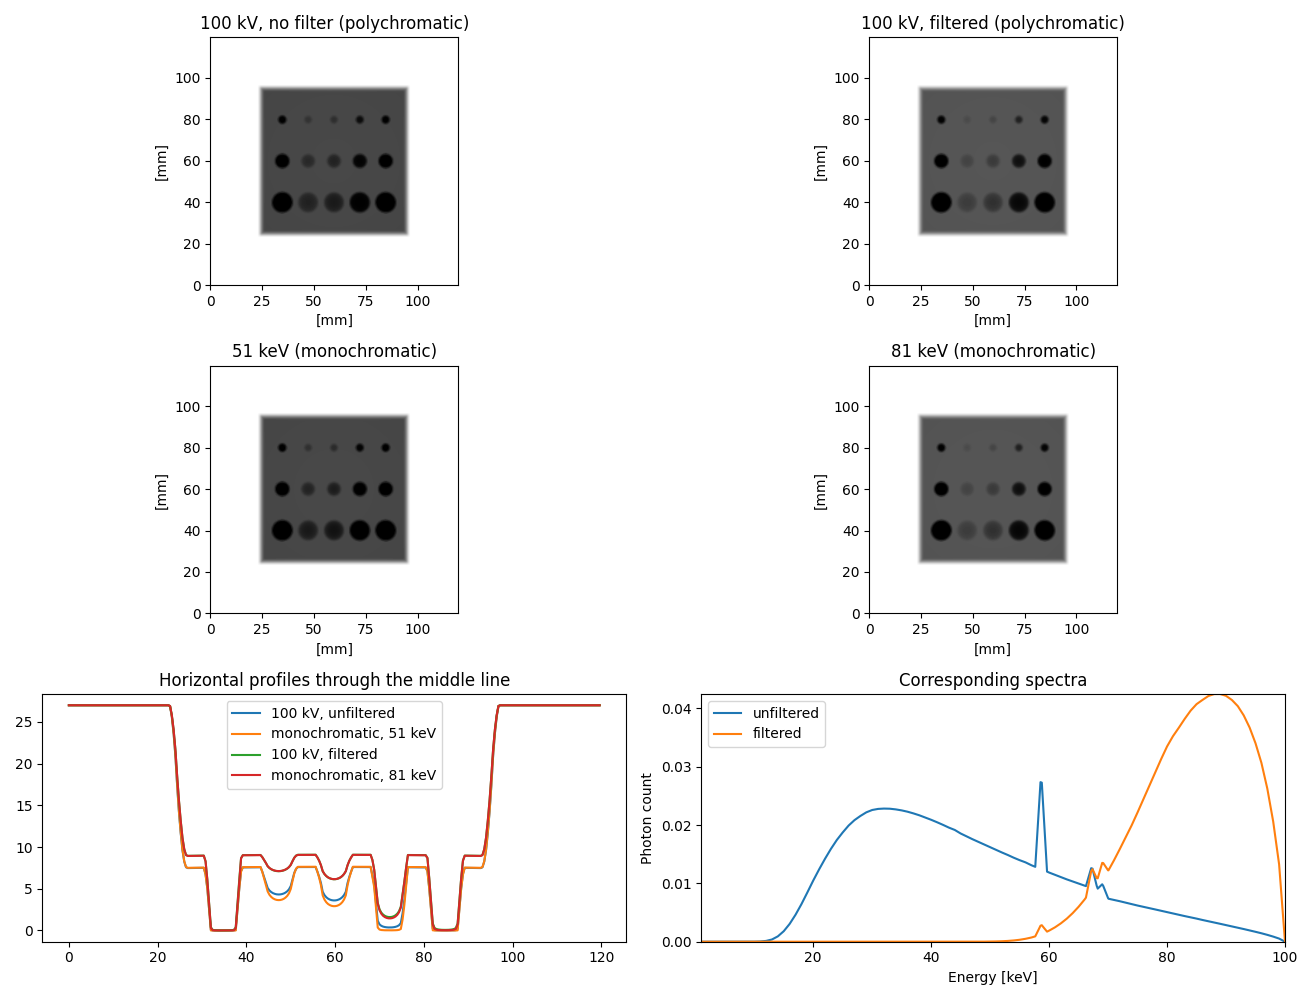

In [57]:
fig, axs = plt.subplots(3, 2, figsize=(13, 10))

extent=[0, (number_of_pixels[0] - 1) * pixel_size[0],
        0, (number_of_pixels[1] - 1) * pixel_size[1]
]

axs[0, 0].imshow(xray_image_100kV_unfiltered, cmap="gray", extent=extent)
axs[0, 0].set_title("100 kV, no filter (polychromatic)")
axs[0, 0].set_xlabel("[mm]")
axs[0, 0].set_ylabel("[mm]")


axs[0, 1].imshow(xray_image_100kV_filtered, cmap="gray", extent=extent)
axs[0, 1].set_title("100 kV, filtered (polychromatic)")
axs[0, 1].set_xlabel("[mm]")
axs[0, 1].set_ylabel("[mm]")

axs[1, 0].imshow(xray_image_51keV, cmap="gray", extent=extent)
axs[1, 0].set_title("51 keV (monochromatic)")
axs[1, 0].set_xlabel("[mm]")
axs[1, 0].set_ylabel("[mm]")

axs[1, 1].imshow(xray_image_81keV, cmap="gray", extent=extent)
axs[1, 1].set_title("81 keV (monochromatic)")
axs[1, 1].set_xlabel("[mm]")
axs[1, 1].set_ylabel("[mm]")

x = np.linspace(0, (number_of_pixels[0] - 1) * pixel_size[0], number_of_pixels[0])
axs[2, 0].plot(x, xray_image_100kV_unfiltered[half_image_width], label="100 kV, unfiltered")
axs[2, 0].plot(x, xray_image_51keV[half_image_width], label="monochromatic, 51 keV")
axs[2, 0].plot(x, xray_image_100kV_filtered[half_image_width], label="100 kV, filtered")
axs[2, 0].plot(x, xray_image_81keV[half_image_width], label="monochromatic, 81 keV")
# axs[2, 0].set_xlim([100, 500])
axs[2, 0].legend()
axs[2, 0].set_title("Horizontal profiles through the middle line")


axs[2, 1].plot(k_unfiltered, f_unfiltered, label="unfiltered")
axs[2, 1].plot(k_filtered, f_filtered, label="filtered")
axs[2, 1].set_xlabel("Energy [" + units + "]")
axs[2, 1].set_ylabel("Photon count")
axs[2, 1].legend()
axs[2, 1].set_title("Corresponding spectra")

plt.tight_layout()
plt.margins(0,0)

In [58]:
gvxr.terminate()